# Learning Position Auctions

In this tutorial, we will extend the ideas from the [previous tutorial](learning-auctions-interdependence.ipynb).  We will consider position auctions, like those found in paid search marketplaces.

## Motivating example

Consider a three-bidder, two-slot position auction where the values for the three bidders are correlated.  There is a signal $c\sim U[0,1]$, which we intepret as a _conversion rate_.  The value of the item for bidder 1 is a random variable $v_1 = x_1 c$ where $x_1 \sim U[0,1]$, similarly for bidder 2 and bidder 3 with independent $x_i \sim U[0,1]$.

The first slot has a click-through-rate (quality) of 1.  The second slot has a click-through-rate of 0.5.  A bidder may purchase one slot only, so we can consider this a special case of a multi-item, unit-demand scenario.

## Architectures and supporting functions

As in the previous tutorial, we will make use of RegretNet.

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

All mechanism networks will output allocations and payments.  The allocation shape is `[batch_size, bidders]`.  The columns represent the probability that the item is allocated to the respective bidder.  The payment shape is `[batch_size, bidders]`.  Here each column represents the payment of the respective bidder.

We define a generic mechanism as follows:

In [3]:
from dmch import Mechanism


We define a position mechanism as a `sequential slot mechanism` as a mechanism where each slot is allocated sequentially to the remaining (non-winning) bidders.  The slot allocations and payments can be weighted with a slot-dependent factor.

In [4]:
from dmch import SequentialMechanism


class WeightedSequentialMechanism(nn.Module):
    def __init__(self, mechanism, slot_weights):
        super(WeightedSequentialMechanism, self).__init__()
        self.mechanism = mechanism
        self.slot_weights = slot_weights
        
    def forward(self, x, signals):
        allocations, payments = mechanism(x, signals)
        for weight, mechanism in zip(self.slot_weights, self.slot_mechanisms):
            allocation, payment = mechanism(x, signals)
            allocations.append(weight * allocation)
            payments.append(weight * payment)
            x = (1-allocation) * x
        return sum(allocations), sum(payments)

Utility can thusly be calculated by:

In [5]:
def calc_utility(bids, signals, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids, signals)
    if output_components:
        return allocation*valuation-payment, allocation, payment
    else:
        return allocation*valuation-payment

The `calc_utility` function will return a tensor of shape `[batch_size,bidders]`.

In order to determine if a mechanism is (approximately) DSIC, we calculate regret:

In [6]:
def calc_regret(values, signals, mechanism, responders, leaky=False):
    u_true, a_true, p_true = calc_utility(values, signals, mechanism, output_components=True)
    regret = torch.zeros(values.shape).to(device)
    for bidder, responder in enumerate(responders):
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,bidder] = 1.0
        response = responder(values, a_true, p_true)
        u_response = calc_utility(response, signals, mechanism, values)
        if leaky:
            regret = regret + F.leaky_relu((u_response - u_true) * bidder_mask)
        else:
            regret = regret + F.relu((u_response - u_true) * bidder_mask)
    return regret.mean(dim=0)

Finally, we can define the evaluation and training function.  In the evaluation function, the mechanisms are not learning, whereas in the training function they are.  In both cases, the responders are learning and are used to calculate the expected DSIC and IR violations.

In [7]:
import torch.optim as optim
import torch.utils.data as data_utils
from tqdm import tqdm


def evaluate(mechanism, responders, values_and_signals_loader, epochs=1, rho=100, allowable_dsic_violation=0, allowable_ir_violation=0):
    # Initalize the optimizer
    responder_optimizers = [optim.Adam(r.parameters(), lr=1e-4) for r in responders]
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_and_signals_loader):
            values = values_list[0].to(device)
            signals = values_list[1].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                values, signals, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = F.relu(calc_regret(
                values,
                signals,
                mechanism,
                responders)-allowable_dsic_violation)
    
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item()})
            
            for bidder, responder in enumerate(responders):
                optimizer = responder_optimizers[bidder]
                optimizer.zero_grad()
                regret = calc_regret(
                    values, 
                    signals,
                    mechanism,
                    responders,
                    leaky=True)
                (-regret[bidder]).backward()
                optimizer.step()
            
    return pd.DataFrame(report_data)

def train(mechanism, responders, values_and_signals_loader, epochs=1, rho=100, allowable_dsic_violation=0, allowable_ir_violation=0):
    # Initialize augmented lagrangian parameters
    lambda_dsic = torch.zeros(bidders).to(device)
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-3)
    responder_optimizers = [optim.Adam(r.parameters(), lr=1e-4) for r in responders]
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_and_signals_loader):
            values = values_list[0].to(device)
            signals = values_list[1].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                values, signals, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = F.relu(calc_regret(
                values,
                signals,
                mechanism,
                responders)-allowable_dsic_violation)
    
            # compute individual rationality violation
            ir_violation = F.relu(F.relu(-utility)-allowable_ir_violation).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_dsic*dsic_violation).sum()\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_dsic_violation.pow(2)+total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
        
            # Clip the norm to prevent exploding gradients
            nn.utils.clip_grad_norm_(mechanism.parameters(), 1.0)
            
            # Take a step towards the gradient
            mechanism_optimizer.step()
            
            with torch.no_grad():
                mechanism.eval()
                for responder in responders:
                    responder.eval()
                    
                # Update the augmented lagrangian parameters
                dsic_violation_next = F.relu(calc_regret(
                    values,
                    signals,
                    mechanism,
                    responders)-allowable_dsic_violation)
                u_next = calc_utility(values, signals, mechanism)
                ir_violation_next = F.relu(F.relu(-u_next)-allowable_ir_violation).mean(dim=0)
                lambda_dsic = lambda_dsic + rho * dsic_violation_next
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
                for responder in responders:
                    responder.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
            
            for bidder, responder in enumerate(responders):
                optimizer = responder_optimizers[bidder]
                optimizer.zero_grad()
                regret = calc_regret(
                    values,
                    signals,
                    mechanism,
                    responders,
                    leaky=True)
                (-regret[bidder]).backward()
                optimizer.step()
            
    return pd.DataFrame(report_data)   

Now we define the auction scenario:

In [8]:
# Number of bidders
bidders = 3

# Pr(click|position)
slot_weights = [1, 0.5]

# Number of slots
slots = len(slot_weights)


## Responder

The responder network computes the best response to the mechanism.

In [9]:
class Responder(nn.Module):
    def __init__(self, bidder, hidden_units):
        super(Responder, self).__init__()
        self.bidder = bidder
        self.initial_layer = nn.Linear(2, hidden_units)
        self.hidden_layer = nn.Linear(hidden_units, hidden_units)
        self.final_layer = nn.Linear(hidden_units, 1)
        
    def forward(self, values, allocation, payment):
        x = torch.cat((allocation[:,self.bidder].unsqueeze(1), payment[:,self.bidder].unsqueeze(1)), dim=1)
        x = F.leaky_relu(self.initial_layer(x))
        x = F.leaky_relu(self.hidden_layer(x))
        x = torch.sigmoid(self.final_layer(x))
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,self.bidder] = 1.0
        return (1-bidder_mask)*values + bidder_mask * values * x

## GSP

For comparison, we define the GSP mechanism by using sequantial second-price auctions (SPA):

In [10]:
class SpaAllocation(nn.Module):
    def __init__(self, kappa=1e4):
        super(SpaAllocation, self).__init__()
        assert kappa > 0
        self.kappa = kappa
        
    def forward(self, x, signals):
        bids_plus_dummy = torch.cat([x, torch.zeros(x.shape[0],1).to(device)], dim=1)
        return torch.softmax(self.kappa*bids_plus_dummy, dim=1)[:,:-1]

class SpaPayment(nn.Module):
    def __init__(self):
        super(SpaPayment, self).__init__()
        
    def forward(self, x, signals):
        return torch.stack([x.index_fill(1,torch.tensor([col]).to(device),0).max(dim=1)[0] for col in range(x.shape[1])], dim=1)
    
def create_spa_mechanism():
    return MechanismNet(
        SpaAllocation(),
        SpaPayment())

def create_gsp_mechanism():
    return SequentialSlotMechanismNet(
        [create_spa_mechanism() for _ in range(len(slot_weights))],
        slot_weights)

## RegretNet

The allocation network is defined as follows:

In [11]:
class EmbeddingBlock(nn.Module):
    def __init__(self, bidders, signal_count, embedding_dim):
        super(EmbeddingBlock, self).__init__()
        self.bidders = bidders
        self.linear = nn.Linear(bidders+signal_count, embedding_dim)
        
    def forward(self, x, signals):
        return F.leaky_relu(self.linear(torch.cat((x,signals), dim=1)))

class AllocationBlock(nn.Module):
    def __init__(self, input_dim, bidders):
        super(AllocationBlock, self).__init__()
        self.bidders = bidders
        self.linear = nn.Linear(input_dim, bidders+1)
        
    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)[:, 0:self.bidders]
    
class PricingBlock(nn.Module):
    def __init__(self, input_dim, bidders):
        super(PricingBlock, self).__init__()
        self.linear = nn.Linear(input_dim, bidders)
        
    def forward(self, x):
        return self.linear(x)
    
class ResCell(nn.Module):
    def __init__(self, units):
        super(ResCell, self).__init__()
        self.bn1 = nn.BatchNorm1d(units)
        self.linear1 = nn.Linear(units, units)
        self.bn2 = nn.BatchNorm1d(units)
        self.linear2 = nn.Linear(units, units)
        
    def forward(self, x):
        original = x
        x = self.linear1(F.leaky_relu(self.bn1(x)))
        x = self.linear2(F.leaky_relu(self.bn2(x)))
        return x + original

class ResBlock(nn.Module):
    def __init__(self, layers, units):
        super(ResBlock, self).__init__()
        assert layers > 0
        self.res_cells = nn.ModuleList([ResCell(units) for _ in range(layers)])
        
    def forward(self, x):
        for cell in self.res_cells:
            x = cell(x)
        return x

In [12]:
class RegretNetAllocation(nn.Module):
    def __init__(self, bidders, signal_count, hidden_layers, hidden_units):
        super(RegretNetAllocation, self).__init__()
        self.embedding = EmbeddingBlock(bidders, signal_count, hidden_units)
        self.res_block = ResBlock(hidden_layers, hidden_units)
        self.allocation = AllocationBlock(hidden_units, bidders)
        
    def forward(self, x, signals):
        x = self.embedding(x,signals)
        x = self.res_block(x)
        return self.allocation(x)

The payment network is defined as follows:

In [86]:
class RegretNetPayment(nn.Module):
    def __init__(self, bidders, signal_count, hidden_layers, hidden_units):
        super(RegretNetPayment, self).__init__()
        self.embedding = EmbeddingBlock(bidders, signal_count, hidden_units)
        self.res_block = ResBlock(hidden_layers, hidden_units)
        self.pricing = PricingBlock(hidden_units, bidders)
        
    def forward(self, x, signals):
        x = self.embedding(x,signals)
        x = self.res_block(x)
        return self.pricing(x)

Finally, we can define the RegretNet mechanism:

In [87]:
def create_regret_net(bidders, signal_count, hidden_layers=2, hidden_units=100):
    return MechanismNet(
        RegretNetAllocation(bidders, signal_count, hidden_layers, hidden_units),
        RegretNetPayment(bidders, signal_count, hidden_layers, hidden_units))

def create_position_regret_net(bidders, signal_count, hidden_layers=10, hidden_units=10):
    return SequentialSlotMechanismNet(
        [create_regret_net(bidders, signal_count, hidden_layers=hidden_layers, hidden_units=hidden_units) for _ in range(len(slot_weights))],
        slot_weights)

## Auction for the motivating example



The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [77]:
sample_size = 2**11
batch_size = 2**8
epochs = 1000

indepedent_components = torch.rand(sample_size, bidders)
common_components = torch.rand(sample_size, 1)
values = indepedent_components * common_components

values_and_signals_loader=data_utils.DataLoader(
    data_utils.TensorDataset(values, common_components),
    batch_size=batch_size)

Before training the networks, let's establish a GSP baseline.

In [78]:
gsp_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]
gsp = create_gsp_mechanism()
gsp_report = evaluate(gsp, gsp_responders, values_and_signals_loader, epochs=epochs)

100%|██████████| 1000/1000 [07:30<00:00,  1.59it/s]


We now create a simple RegretNet instance.

In [93]:
regret_net = create_position_regret_net(bidders,1).to(device)
regret_net_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]

We loop over the data for a number of epochs and record traces of the networks learning.

In [94]:
regret_net_report = train(regret_net, regret_net_responders, values_and_signals_loader, epochs=epochs)

100%|██████████| 1000/1000 [1:08:15<00:00,  4.33s/it]


Next, let's review the DSIC violations of the network. In the figure below, we can see that networks have a large initial violation then quickly finds a region with low and decreasing violation.

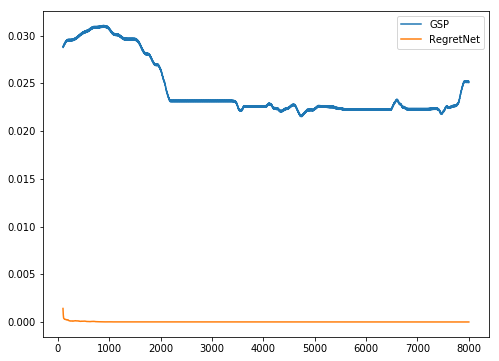

In [91]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(gsp_report[['total_dsic_violation']].rolling(100).mean(), label='GSP');
ax.plot(regret_net_report[['total_dsic_violation']].rolling(100).mean(), label='RegretNet');
ax.legend();

Let's review the revenue of the network: RegretNet approaches GSP revenue with less violation.

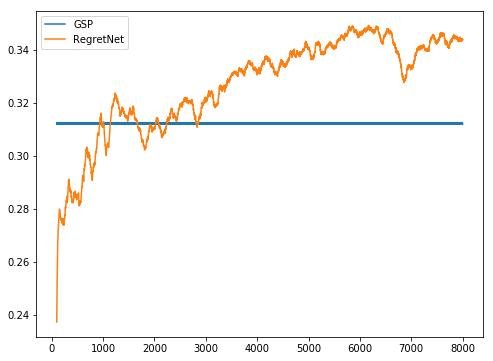

In [92]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(gsp_report[['revenue']].rolling(100).mean(), label='GSP');
ax.plot(regret_net_report[['revenue']].rolling(100).mean(), label='RegretNet');
ax.legend();